# Audio Feature Extraction Tutorial
> A tutorial on audio feature extraction for use in machine learning

- toc: true 
- badges: true
- comments: true
- categories: [audio]
- image: images/chart-preview.png

In [59]:
#collapse-output
! pip install numpy tensorflow tensorflow_hub tensorflow-io matplotlib pydub

# About

This tutorial will cover the subject of extracting useful signals (features) from audio inputs, for use in applications such as machine learning. We will cover the motivation and methodology behind feature extraction, with specific examples in the audio domain. The goal is to build some intuition around analyzing audio signals, and how to integrate audio features into a complete system. We will build two feature extraction pipelines:

1. [YAMNet](https://tfhub.dev/google/yamnet/1) - audio event classification on 521 events, via a model trained by Google using YouTube data.
2. DeepSpeech - speech-to-text

# Features

A feature is the output of some transformation of an input (or set of inputs), and the process of transformation is termed feature extraction. The following are examples of features that can be extracted from an audio sample:

- duration
- root-mean-square amplitude
- detecting the presence of music
- detecting the presence of speech
- speech-to-text
- detecting the presence of a set of audio events (classification)

Features like duration and RMS amplitude are single values representing the input. Features like speech-to-text require more than a single value to represent. Features can be real numbers, boolean values, lists of numbers, audio signals (transformed from the input), and just about anything really. Which ones you would choose to use depends on the application. Note a pattern in these example features. They all reduce the amount of information from the input to a smaller amount. We can go through a comparative analysis to get some intuition on why this is important.

# Dimensionality Reduction

The way we hear and interpret sound is [complex](https://www.nidcd.nih.gov/health/how-do-we-hear). We interpret electrical signals in our brains, sent by the auditory nerve, which is a transduction product of chemical interactions induced by vibrating hair cells, and so on to the other mechanisms of the human auditory system, which are ultimately induced by vibrations in the air. Vibrations in the air are due to trillions of molecules bumping into each other, which is a gas that has a temperature and is moving in transverse waves. From the sound source, these waves bounce around and interact with the environment before they reach their destination.

If the goal is to describe the properties of a specific sound, we could make the argument that we need to describe all of the above, because it is all a part of the process of our perception of the sound. To the best understanding of reality as we know it, the most fundamental description can be expressed in quantum field theory, and that the number of [bits](https://en.wikipedia.org/wiki/Bekenstein_bound) necessary to do so assuming we are in a small room might be around 10^45. This is infeasible.

Our intuition about sound tells us that we can ignore most of the above processes in typical situations, since the environmental and biological processes are separable from the information content of the underlying signal itself. A description of the underlying audio signal, which can be used to reconstruct the physical processes of sound to the limits of human perception, can be expressed in 10^6 bits per second. A signal such as this can be converted from electrical waves to sound waves via a transducer, e.g. a speaker, and will approximately reconstruct the sound well enough for most situations. Further perceptual "hacks" can lower this even further, e.g. lossy compression schemes like mpeg-3.

We can express the above intuition about this underlying signal, separate from the physical processes, via the concept of [intrinsic dimension](https://en.wikipedia.org/wiki/Intrinsic_dimension), which is the minimum number of variables necessary to represent the properties of sound we care about, and to a good enough approximation for the given situation. Dimensionality reduction is the process of reducing the number of variables needed to describe the sound, ideally reduced down to its intrinsic dimension.

## Curse of Dimensionality

Further motivation for dimensionality reduction in the context of metric spaces.

# Audio Signal Fundamentals

Before moving into the specific feature transformations, it is worth pointing out some properties of the types of inputs we will be dealing with.

## Sampling

Sound, in the real world, is represented as an idealized continuous function of time:

$$ x(t) $$

We transform it into a discrete representation by periodic sampling, idealized as the following:

$$ x[n] = x(Tn) , n = \{-\infty, ..., 0, 1, ..., \infty \} $$

$ T $ is the sampling period (in seconds per sample), which can also be expressed as the sampling frequency $ f_s = \frac{1}{T} $ (samples per second, or Hz). Sampling a signal has some significant implications, one of which deserves mention here and has a name: the Nyquist sampling theorem. This theorem essentially states that for a signal to be fully reconstructable, that the sampling rate must be twice the largest non-zero frequency component of the signal. In signal parlance, the signal must be band-limited (amplitude of frequencies greater than a certain amount is zero), and sampling must be twice as much as that. This is a pretty high-level handwave description of the theorem, and there are many resources available out there to give it more rigor.

## Quantization

A discrete-time signal can be converted to a "digital" signal by quantizing the samples. We can choose to represent each sample, representing the amplitude, with a certain number of bits. The number of bits needed depends on the situation. It is related to the dynamic range of the signal, which is the ratio between the largest and smallest values that can be represented by the number of bits available. For sound, humans are capable of handling ratios exceeding 100000, which is often expressed in decibels as $ 20\log_{10}(100000) = 100 $ db. Quantizing audio samples at 16-bits provides $ 20\log_{10}(2^{16}) = 96 $ db. There is much more on the subject, e.g. quantization error, dithering and other topics.
 
# Features

The purpose of feature extraction is to create a more information-dense representation of the input. Here we will get some intuition of what this means for audio signals. We will start with simple features, and move to more complex ones. 

## Signal Energy

The energy of a discrete-time signal $ x[n] $ is [defined](https://en.wikipedia.org/wiki/Energy_(signal_processing)) as

$$ E=\sum_{-\infty}^{\infty}\lvert x[n] \rvert^2 $$

Note that sample rate is not part of the definition. Audio samples that we might be interested in are finite duration ($ N $ samples), which be expressed by something the following discontinuous function:

$$ x[n] = \begin{cases}
0 & x\lt 0 \\
x[n] & 0\leq n\leq N \\
0 & N\leq n 
\end{cases}
$$

The implication of this is that the energy is finite for such "real-world" audio signals:

$$ E=\sum_{-\infty}^{\infty}\lvert x[n] \rvert^2 = \sum_{0}^{N}\lvert x[n] \rvert^2 $$

Since energy is a function of the duration of the signal, it is sometimes more helpful to look at an average over the duration, which is signal average "power". The definition isn't precise, as technically average power for the signal above is zero (most of the signal is zero outside the non-zero interval, out to infinity, so the average power converges to zero). But we only really care about the finite sample, so lets ignore the mathematical precision by defining average energy as:

$$ P = \frac{E}{N} = \frac{1}{N} \sum_{0}^{N}\lvert x[n] \rvert^2 $$

In [52]:
P = lambda x: 1/len(x) * np.sum(x**2)

There are other implications of discontinous functions in general, which we can ignore for the moment. We can test the behavior of this transformation with some test input signals. We can use the `numpy` Python library to construct 2 second clips of some test signals:

* "all zeros" signal: $ x[n] = 0 $
* 1000 Hz tone: $ x[n] = \sin(2\pi 1000 T n) $
* 10000 Hz tone: $ x[n] = \sin(2\pi 10000 T n) $

We are going to choose a sample rate and quantization that is common to work with: 32 bits per sample, 16 kHz sample rate.

In [53]:
import numpy as np

fs = 16000
T = 1/fs
duration_s = 2

n = np.arange(0, duration_s/T)  # vector n, dimensionless (no units)
t = n * T  # corresponding vector in unit seconds

zeros = np.zeros(len(n), dtype=np.float32)
tone_1000Hz = np.sin(2*np.pi*1000*T*n)
tone_10000Hz = np.sin(2*np.pi*10000*T*n)

We can then compute the signal average energy for each:

In [58]:
print(f"zeros: {P(zeros)}")
print(f"1000 Hz {P(tone_1000Hz)}")
print(f"10000 Hz {P(tone_10000Hz)}")

zeros: 0.0
1000 Hz 0.4999999999999993
10000 Hz 0.49999999999999845


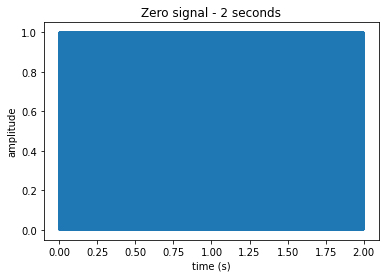

In [43]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Zero signal - 2 seconds")
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.plot(t, tone_1000Hz**2)

## YAMNet Audio classifier
This section will cover the YAMNet audio classifier.

A pretrained model can be downloaded from Tensorflow Hub:

In [3]:
import tensorflow_hub as hub

model = hub.load('https://tfhub.dev/google/yamnet/1')

From the model [documentation]():
> The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as mono 16 kHz samples in the range [-1.0, +1.0]

A useful test signal, to investigate how the model behaves, is all zeros. From the above statement, the input to the model is a 1-D vector of floating point numbers. We will construct a 2 second audio signal of zero amplitude everywhere. This means we need $N=16000*2=32000$ samples. We will return to discuss the implications of the sample rate in particular.

From the model [documentation](https://tfhub.dev/google/yamnet/1), the model has three outputs:

In [63]:
scores, embeddings, log_mel_spectrogram = model(zeros)

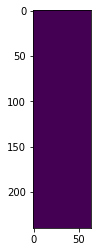

In [64]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure()
ax = plt.imshow(log_mel_spectrogram.numpy())